In [1]:
using MAT
using NPZ
using Glob
using WebIO
using PyPlot
using Eirene
using Random
using Statistics
using Clustering
using DelimitedFiles

rng = MersenneTwister(1337);

HTML{String}("<script>\n// Immediately-invoked-function-expression to avoid global variables.\n(function() {\n    var warning_div = document.getElementById(\"webio-warning-11420451921814156141\");\n    var hide = function () {\n        var script = document.getElementById(\"webio-setup-11678286707747738836\");\n        var parent = script && script.parentElement;\n        var grandparent = parent && parent.parentElement;\n        if (grandparent) {\n            grandparent.style.display = \"none\";\n        }\n        warning_div.style.display = \"none\";\n    };\n    if (typeof Jupyter !== \"undefined\") {\n        console.log(\"WebIO detected Jupyter notebook environment.\");\n        // Jupyter notebook.\n        var extensions = (\n            Jupyter\n            && Jupyter.notebook.config.data\n            && Jupyter.notebook.config.data.load_extensions\n        );\n        if (extensions && extensions[\"webio-jupyter-notebook\"]) {\n            // Extension already loaded.\n            console.log(\"Jupyter WebIO nbextension detected; not loading ad-hoc.\");\n            hide();\n            return;\n        }\n    } else if (window.location.pathname.includes(\"/lab\")) {\n        // Guessing JupyterLa\n        console.log(\"Jupyter Lab detected; make sure the @webio/jupyter-lab-provider labextension is installed.\");\n        hide();\n        return;\n    }\n})();\n\n</script>\n<p\n    id=\"webio-warning-11420451921814156141\"\n    class=\"output_text output_stderr\"\n    style=\"padding: 1em; font-weight: bold;\"\n>\n    Unable to load WebIO. Please make sure WebIO works for your Jupyter client.\n    For troubleshooting, please see <a href=\"https://juliagizmos.github.io/WebIO.jl/latest/providers/ijulia/\">\n    the WebIO/IJulia documentation</a>.\n    <!-- TODO: link to installation docs. -->\n</p>\n")

#### Load experimental data

In [2]:
filelist = glob("EGF(E6)w*.mat", "experimental-data")
sz = size(filelist)[1];

well_nums = []
particle_pos = []

for i in 1:sz
    
    filenamewext = split(filelist[i], '/')[2]
    filename = split(filenamewext, '.')[1]
    well_num = parse(Int, split(filename, 'w')[2])
    
    mat_variables = matread(filelist[i])
    pos_x = mat_variables["storeX"]
    pos_y = mat_variables["storeY"]
    pos_x_final = pos_x[1:end, size(pos_x)[2]]
    pos_y_final = pos_y[1:end, size(pos_y)[2]]
    pos_x_final = filter!(!(isnan), pos_x_final)
    pos_y_final = filter!(!(isnan), pos_y_final)
    pos_final = hcat(pos_x_final, pos_y_final)
    pos_final = transpose(pos_final)
    
    push!(well_nums, well_num)
    push!(particle_pos, pos_final)
    
end

#### Sort by well number

In [3]:
sort_idx = sortperm(well_nums)
well_nums = well_nums[sort_idx];
particle_pos = particle_pos[sort_idx];

densities = [500, 500, 500, 1000, 1000, 1000, 
             1000, 1000, 1000, 500, 500, 500,
             500, 500, 500, 1000, 1000, 1000,
             1000, 1000, 1000, 500, 500, 500];

conditions = ["GM", "Gefitinib", "Assay", "GM", "Gefitinib", "Assay",
             "Assay", "Gefitinib", "GM", "Assay", "Gefitinib", "GM",
             "GM", "Gefitinib", "Assay", "GM", "Gefitinib", "Assay",
             "Assay", "Gefitinib", "GM", "Assay", "Gefitinib", "GM"];

#### Plot experimental condition

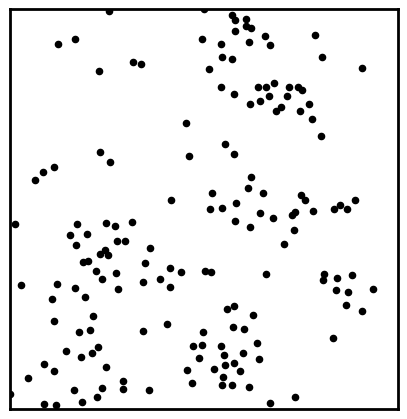

Well 71 Gefitinib 500 cells
Number of cells 168

In [4]:
cnt = 23
print("Well " * string(well_nums[cnt]) * " " * conditions[cnt] * " " * string(densities[cnt]) * " cells\n");
print("Number of cells " * string(size(particle_pos[cnt])[2]));

figure(figsize=(5,5), dpi=300)

scatter(particle_pos[cnt][1,:], particle_pos[cnt][2,:], color="black");

xlim([0, 900]);
ylim([0, 900]);
xticks([]);
yticks([]);

ax = gca()
ax.spines["top"].set_linewidth(2.0)
ax.spines["bottom"].set_linewidth(2.0)
ax.spines["left"].set_linewidth(2.0)
ax.spines["right"].set_linewidth(2.0)

show()

#### Plot simulation result

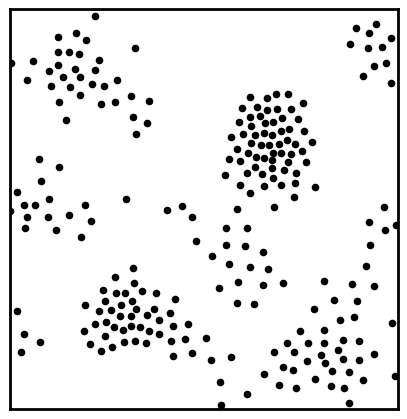

In [12]:
adh_pol_sweep_folder = "adhesion_polarity_proliferation_sweep";

adh = 10
pol = 6

subfolder = string(adh) * "_adh_" * string(pol) * "_pol"

pos_file_path = adh_pol_sweep_folder * "/" * subfolder * "/Pos_200000.dat"
posarray = readdlm(pos_file_path, ',', '\n');
posx = [];
posy = [];
for j in 1:size(posarray)[2]
    complex_num = parse(Complex{Float64}, posarray[j])
    push!(posx, real(complex_num));
    push!(posy, imag(complex_num));    
end

figure(figsize=(5,5), dpi=300)

scatter(posx, posy, color="black");

xlim([-10, 10]);
ylim([-10, 10]);
xticks([]);
yticks([]);

ax = gca()
ax.spines["top"].set_linewidth(2.0)
ax.spines["bottom"].set_linewidth(2.0)
ax.spines["left"].set_linewidth(2.0)
ax.spines["right"].set_linewidth(2.0)

show()

In [6]:
function get_pos(well_num, time)
    
    @assert 1 < time
    @assert time <= 249
    
    pathstring = "experimental-data/EGF(E6)w" * string(well_num) * ".mat"
    mat_variables = matread(pathstring)
    pos_x = mat_variables["storeX"]
    pos_y = mat_variables["storeY"]
    pos_x_t = pos_x[1:end, time]
    pos_y_t = pos_y[1:end, time]
    pos_x_t = filter!(!(isnan), pos_x_t)
    pos_y_t = filter!(!(isnan), pos_y_t)
    max_lim = maximum([maximum(pos_x_t), maximum(pos_y_t)])
    min_lim = minimum([minimum(pos_x_t), minimum(pos_y_t)])
    pos_x_t = -10 .+ 20*((pos_x_t .- min_lim)./(max_lim - min_lim))
    pos_y_t = -10 .+ 20*((pos_y_t .- min_lim)./(max_lim - min_lim))
    pos_t = hcat(pos_x_t, pos_y_t)
    pos_t = transpose(pos_t)
    
end

get_pos (generic function with 1 method)

#### Compare experiments to simulations

In [7]:
pol_vals = range(0.005, stop=0.025, length=11);
adh_vals = range(0.05, stop=0.25, length=11);

adh_pol_sweep_folder = "adhesion_polarity_proliferation_sweep";

cnt = 1
for w_id in well_nums
    
    well_pos = get_pos(w_id, 249);
    
    ref_pers_diag = eirene(well_pos, model="pc", maxdim=1);
    ref_barcode = barcode(ref_pers_diag, dim=1);
    
    print("Well " * string(w_id) * " Condition: " * string(conditions[cnt]) * " Density: " * repr(densities[cnt]))
    print("\n")
    
    wasserstein_distances_ref1 = Array{Float64}(undef, 11, 11);
    min_dist = Inf
    min_adh = -1
    min_pol = -1
    
    for adh = 1:11
        for pol = 3:11
            
            subfolder = string(adh) * "_adh_" * string(pol) * "_pol"
            pos_file_path = adh_pol_sweep_folder * "/" * subfolder * "/Pos_200000.dat"
            posarray = readdlm(pos_file_path, ',', '\n');
            posx = [];
            posy = [];
            for j in 1:size(posarray)[2]
                complex_num = parse(Complex{Float64}, posarray[j])
                push!(posx, real(complex_num));
                push!(posy, imag(complex_num));    
            end
            positions = transpose(hcat(posx, posy));  
            
            pers_diag = eirene(positions, model="pc", maxdim=1);
            barcodedata = barcode(pers_diag, dim=1);
            
            w_dist = wasserstein_distance(ref_barcode, barcodedata, q=2, p=2)
            wasserstein_distances_ref1[adh, pol] = w_dist
            
            if w_dist < min_dist
                min_dist = w_dist
                min_adh = adh
                min_pol = pol
            end
            
        end
    end
    
    print("Minimum Wasserstein Distance: " * string(min_dist) * "\n")
    print("Adh: " * string(min_adh) * " Pol: " * string(min_pol) * "\n")
    print("\n")
    
    cnt += 1
    
end

Well 1 Condition: GM Density: 500
Minimum Wasserstein Distance: 1.1566549560803088
Adh: 4 Pol: 10

Well 2 Condition: Gefitinib Density: 500
Minimum Wasserstein Distance: 2.405551071652838
Adh: 4 Pol: 3

Well 3 Condition: Assay Density: 500
Minimum Wasserstein Distance: 1.7836465898932996
Adh: 11 Pol: 6

Well 4 Condition: GM Density: 1000
Minimum Wasserstein Distance: 2.8557560048662487
Adh: 7 Pol: 3

Well 5 Condition: Gefitinib Density: 1000
Minimum Wasserstein Distance: 1.694573797061061
Adh: 9 Pol: 6

Well 6 Condition: Assay Density: 1000
Minimum Wasserstein Distance: 1.548900434717615
Adh: 6 Pol: 4

Well 19 Condition: Assay Density: 1000
Minimum Wasserstein Distance: 1.6407829006796841
Adh: 7 Pol: 4

Well 20 Condition: Gefitinib Density: 1000
Minimum Wasserstein Distance: 2.1036852665838675
Adh: 11 Pol: 11

Well 21 Condition: GM Density: 1000
Minimum Wasserstein Distance: 2.871868450297963
Adh: 7 Pol: 3

Well 22 Condition: Assay Density: 500
Minimum Wasserstein Distance: 1.283142929

#### Compute peristence diagrams

In [48]:
@time begin

    barcodes = []

    for i in 1:sz
        pers_diag = eirene(particle_pos[i], model="pc", maxdim=1)
        push!(barcodes, barcode(pers_diag))
    end
    
end

 46.776207 seconds (135.74 M allocations: 28.295 GiB, 10.63% gc time)


#### Compute pairwise Wasserstein distances

In [49]:
@time begin
    
    wassmatrix = Array{Float64}(undef, sz, sz);
    for rows in 1:sz
        for cols in 1:sz
            wassmatrix[rows, cols] = wasserstein_distance(barcodes[rows], barcodes[cols], q=2, p=2);
        end
    end
    
end

 77.979330 seconds (532.90 k allocations: 718.178 MiB, 0.05% gc time)


#### Save data for visualization in R and Python

In [ ]:
well_names = []

for i in 1:sz
    treat = ""
    if well_nums[i] < 25
        treat = treat * "DMSO, "
    else
        treat = treat * "OHT, "
    end
    push!(well_names, treat * conditions[i] * ", " * string(densities[i]) * " cells")
end

In [ ]:
npzwrite("wasserstein_matrix_exp.npz", Dict("wassmatrix" => wassmatrix, "densities" => densities, 
        "well_nums" => convert(Array{Int64, 1}, well_nums)))